In [10]:
%load_ext autoreload
%autoreload 2
from paths import *

from matplotlib import pyplot as plt
import torch
from src.SERS_dataset import IterDataset
from src.generate_data2 import pseudoVoigtSimulatorTorch
from src.plotting.save_plot import save_plot
from src.plotting.VAE_plotting import plot_loss, plt_latent_space_ellipses, plt_reconstructions, plot_losses, plot_losses_3_2
from src.models.vanilla_VAE import VariationalAutoencoder
# import make_axes_locatable
import numpy as np
import dill
import io

# matplotlib style seaborn-whitegrid
plt.style.use('seaborn-whitegrid')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\andre\AppData\Local\Temp\ipykernel_15544\3176252513.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [11]:
# load model that has been trained on GPU on CPU. Source https://github.com/pytorch/pytorch/issues/16797
class CPU_Unpickler(dill.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

def load_dill(file_name, experiment):
    file_name = os.path.join(results_dir, experiment, file_name)
    with open(file_name, 'rb') as f:
        contents = CPU_Unpickler(f).load()
    autoencoder = contents["model"]
    train_loss = contents["train_loss"]
    generator_num = contents["generator"]

    return autoencoder, train_loss, generator_num

In [12]:
# model_names = {"winter-galaxy-574": 3, "star-speeder-330": 2, "scruffy-looking-ewok-309": 1}
models = ["winter-galaxy-574", "northern-plant-578", "deft-serenity-581"]
labels_dict = {1: "alpha", 2: "c", 3: ["c", "alpha"]}

In [13]:
ps = pseudoVoigtSimulatorTorch(500)

In [14]:
numbers = {1: "One", 2: "Two", 3: "Three"}

for model_name in models:
    autoencoder, train_loss, generator_num = load_dill(f"{model_name}.dill", "1_AE")

    generator = ps.predefined_generator(generator_num)
    dset_train = IterDataset(generator)
    train_loader = torch.utils.data.DataLoader(dset_train, batch_size=100, pin_memory=cuda)

    loss = []
    loss_mu = []
    for i in range(10):
        x, y = next(iter(train_loader))
        x = x.to(device)
        y = y.to(device)
        z, mu, logvar = autoencoder.encode(x)
        recons = autoencoder.decode(z)
        recons_mu = autoencoder.decode(mu)
        label = labels_dict[generator_num]

        MSE = torch.nn.MSELoss()
        loss.append(MSE(recons, x).item())
        loss_mu.append(MSE(recons_mu, x).item())

    # print mean loss 
    # print("%", "Generator", generator_num, ", Loss: ", np.mean(loss), "Loss (mu) :", np.mean(loss_mu), "(" + model_name + ")")
    print(f"\\def\\VAEMSE{numbers[generator_num]}{{{np.round(np.mean(loss),4)}}}")
    print(f"\\def\\VAEMSE{numbers[generator_num]}Mu{{{np.round(np.mean(loss_mu),4)}}}")





\def\VAEMSEOne{0.251}
\def\VAEMSEOneMu{0.2505}
\def\VAEMSETwo{0.2544}
\def\VAEMSETwoMu{0.2534}
\def\VAEMSEThree{0.2642}
\def\VAEMSEThreeMu{0.2632}


In [15]:
ps = pseudoVoigtSimulatorTorch(500)

Generator 1 (winter-galaxy-574)
   loss 367.59937078302556
   kl 4.212049700997093
   elbo -367.59937078302556
   logpx -363.38732355291194
   MSE 0.2504916489124298
   MSE 0.24889123439788818 (validation batch)

Generator 1 (winter-galaxy-574)
   \def\VAELossOne{367.5994}
   \def\VAEKlOne{4.212}
   \def\VAEElboOne{-367.5994}
   \def\VAELogpxOne{-363.3873}


Generator 2 (northern-plant-578)
   loss 377.90877186168325
   kl 10.003033291209828
   elbo -377.90877186168325
   logpx -367.90573952414775
   MSE 0.25501008467240766
   MSE 0.25461503863334656 (validation batch)

Generator 2 (northern-plant-578)
   \def\VAELossTwo{377.9088}
   \def\VAEKlTwo{10.003}
   \def\VAEElboTwo{-377.9088}
   \def\VAELogpxTwo{-367.9057}


Generator 3 (deft-serenity-581)
   loss 390.4060974121094
   kl 11.497034939852627
   elbo -390.4060974121094
   logpx -378.90909090909093
   MSE 0.26601341366767883
   MSE 0.27089378237724304 (validation batch)

Generator 3 (deft-serenity-581)
   \def\VAELossThree{390.406

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 551.181x257.218 with 0 Axes>

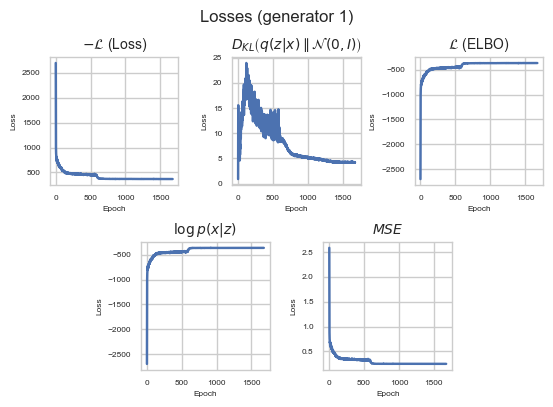

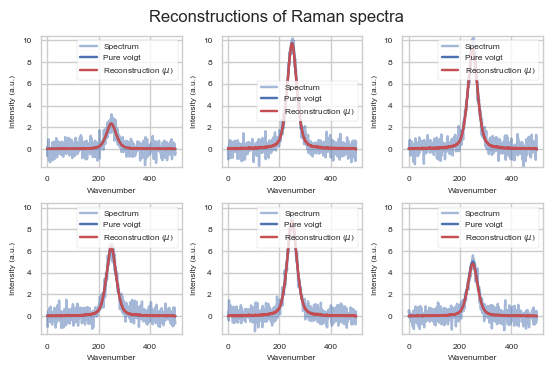

<Figure size 551.181x257.218 with 0 Axes>

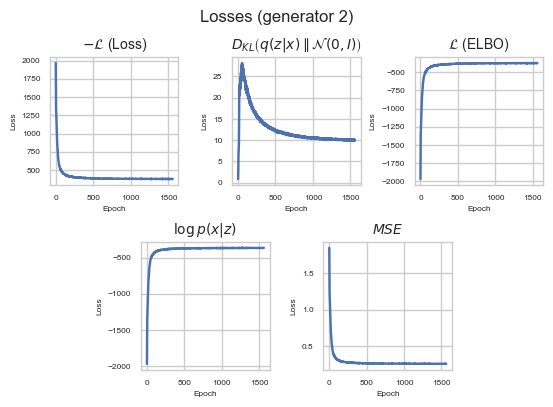

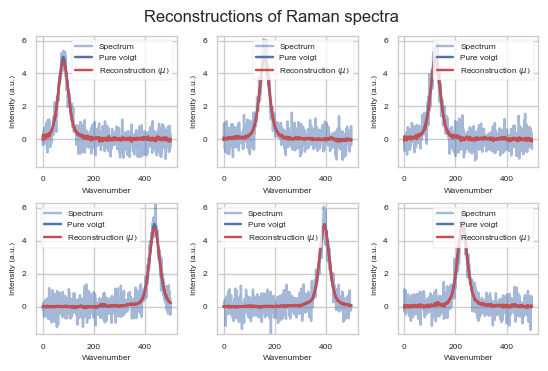

<Figure size 551.181x257.218 with 0 Axes>

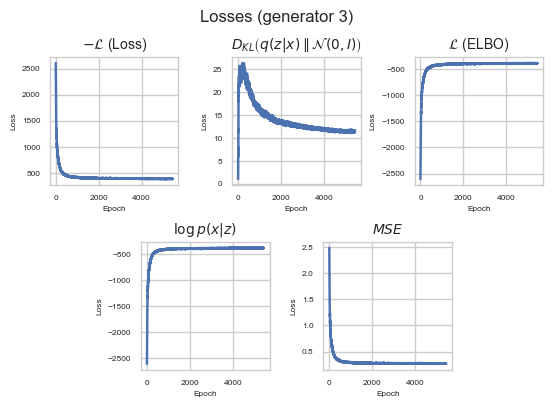

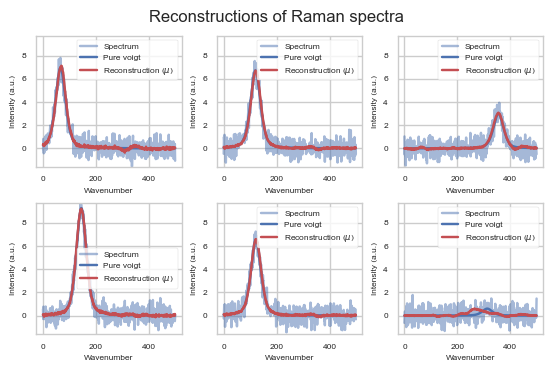

In [47]:
# don't show plots in notebook
# plt.ioff()

for model_name in models:

    autoencoder, train_loss, generator_num = load_dill(f"{model_name}.dill", "2_VAE")

    print("Generator", generator_num, "(" + model_name + ")")
    for key, value in train_loss.items():
        print("  ", key, value[-1])

    # print("Generator", generator_num, ", Loss: ", train_loss[-1])

    generator = ps.predefined_generator(generator_num)
    dset_train = IterDataset(generator)
    train_loader = torch.utils.data.DataLoader(dset_train, batch_size=100, pin_memory=cuda)

    x, y = next(iter(train_loader))
    x = x.to(device)
    y = y.to(device)
    z, mu, logvar = autoencoder.encode(x)
    sigma = torch.exp(0.5 * logvar)
    x_hat = autoencoder.decode(z)
    x_hat_mu = autoencoder.decode(mu)

    x = x.cpu().detach().numpy()
    x_hat = x_hat.cpu().detach().numpy()
    x_hat_mu = x_hat_mu.cpu().detach().numpy()
    sigma = sigma.cpu().detach().numpy()
    mu = mu.cpu().detach().numpy()
    z = z.cpu().detach().numpy()

    loss = ((x_hat_mu - x)**2).mean()

    print("   MSE", loss.item(), "(validation batch)")
    print()

    # recons = autoencoder.decode(z)
    label = labels_dict[generator_num]

    ll = {"c": 0, "gamma": 1, "eta": 2, "alpha": 3}
    labels = []
    if isinstance(label, list):
        for l in label:
            labels.append(y[:,ll[l]])
    else:
        labels.append(y[:,ll[label]])
        label = [label]

    print("Generator", generator_num, "(" + model_name + ")")

    numbers = {1: "One", 2: "Two", 3: "Three"}

    for key, value in train_loss.items():
        # Make first letter of key capital
        key_cap = key[0].upper() + key[1:]
        if key != "MSE":
            print("  ", f"\def\VAE{key_cap}{numbers[generator_num]}{{{np.round(value[-1],4)}}}")
    print()
    # save plots 
    plot = plt_latent_space_ellipses(z, mu, sigma, labels, label, generator_num, 2, width_in_cm=14.5)
    save_plot(plot, os.path.join(report_dir, "figures", "results", "2_VAE", "vae_latent_space_" + "_".join(label)), ["pdf", "png"])
    plot =  plot_losses_3_2(train_loss, generator_num, width_in_cm=14.5)
    save_plot(plot, os.path.join(report_dir, "figures", "results", "2_VAE", "vae_losses_" + "_".join(label)), ["pdf", "png"])
    plot = plt_reconstructions(x, x_hat, x_hat_mu, y, n=3, width_in_cm=14.5)
    save_plot(plot, os.path.join(report_dir, "figures", "results", "2_VAE", "vae_reconstructions_" + "_".join(label)), ["pdf", "png"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


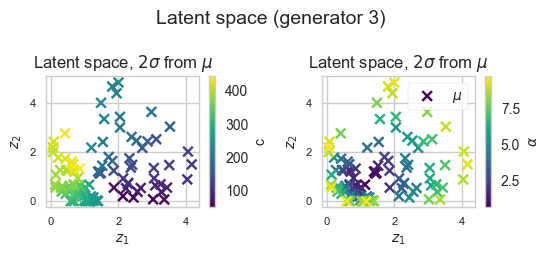

In [41]:
width_in_cm = 14.5

plot = plt_latent_space_ellipses(z, mu, sigma, labels, label, generator_num, 2, width_in_cm=14.5)
# plot.figure().set_figwidth(width_in_cm / 2.54)
# get figure size in inches
# width, height = plot.figure().get_size_inches()

# if width_in_cm is not None:
#     height_ratio = height / width

#     width_in_cm = 14
#     width_in_in = width_in_cm / 2.54
#     # set width to 6 inches
#     plot.figure().set_size_inches(width_in_in, width_in_in * height_ratio)

save_plot(plot, os.path.join(report_dir, "test"), ["pdf", "png"], width_in_cm=12.5)


In [32]:
# Differing beta models
models = {"olive-waterfall-663": 10, "morning-darkness-662": 5, "dauntless-smoke-661": 2, "graceful-dragon-660": 1, "swept-water-659": 0.5}


In [33]:
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.predefined_generator(generator_num)
dset_train = IterDataset(generator)
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=1000, pin_memory=cuda)

x, y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)

C:\Users\andre\AppData\Local\Temp\ipykernel_28636\1297932383.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 800x550 with 0 Axes>

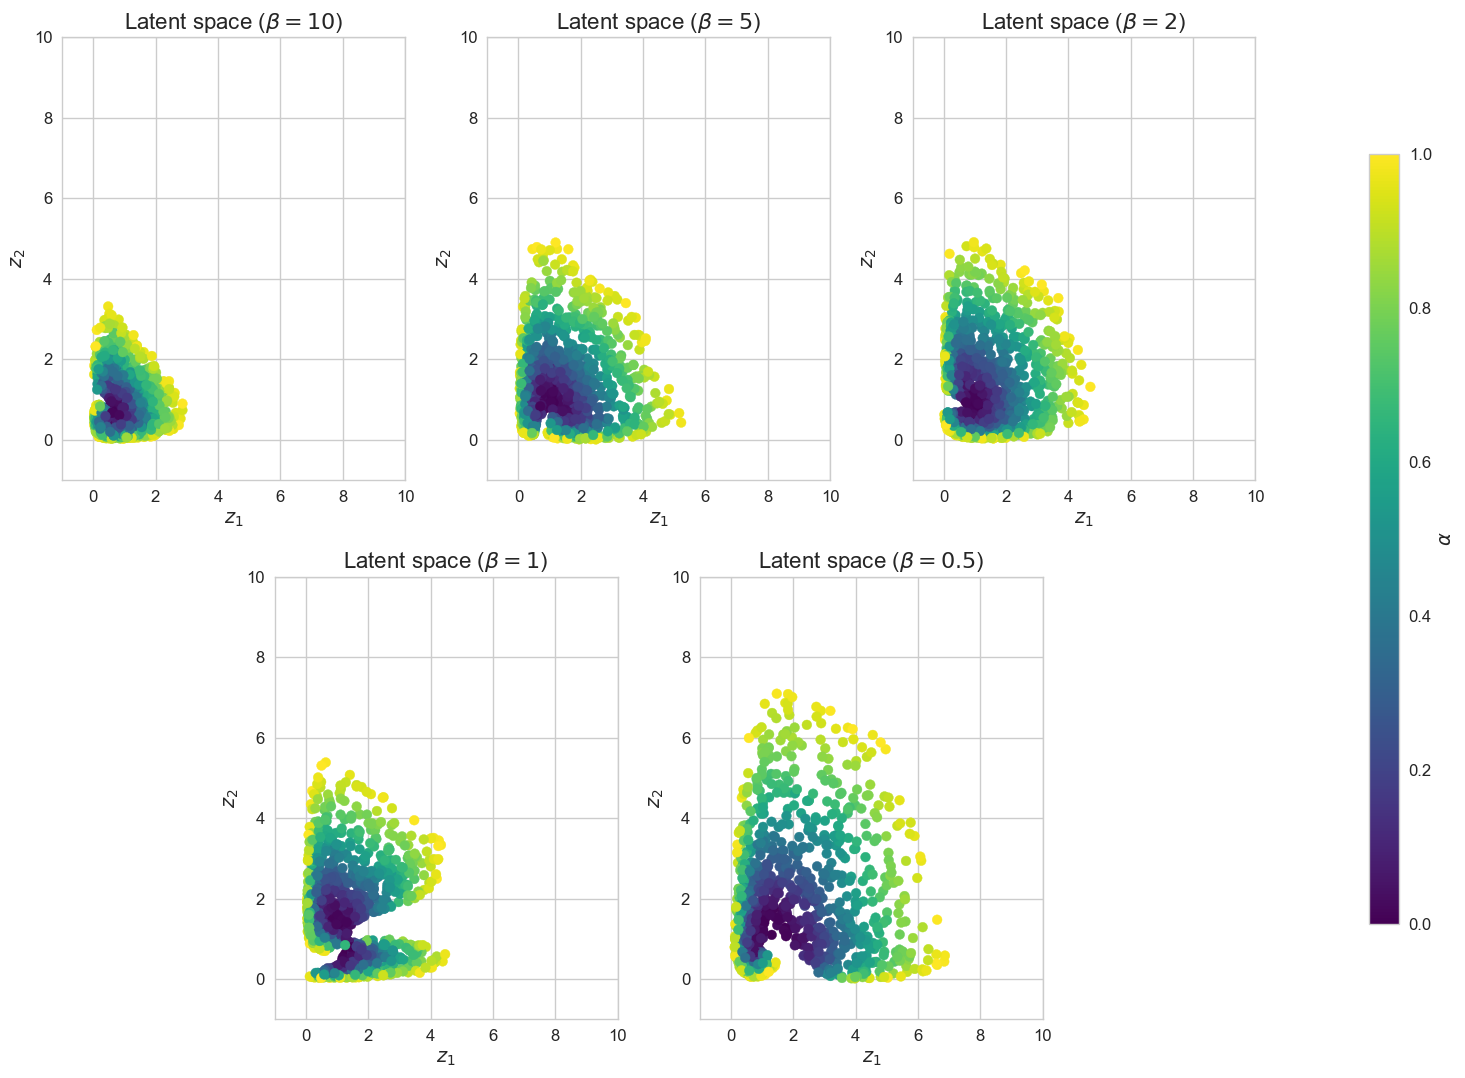

In [39]:
import matplotlib.gridspec as gridspec

# plot 5 loses 
plt.clf()
gs = gridspec.GridSpec(2, 7, width_ratios=[1, 1, 1, 1, 1, 1, 1], height_ratios=[1, 1])
fig = plt.figure(figsize=(15, 11))
axes = [gs[0, :2], gs[0, 2:4], gs[0, 4:6], gs[1, 1:3], gs[1, 3:5]]

for i, (model_name, beta) in enumerate(models.items()):
    autoencoder, train_loss, generator_num = load_dill(f"{model_name}.dill", "2_VAE")

    z, mu, logvar = autoencoder.encode(x)
    sigma = torch.exp(0.5 * logvar)
    x_hat = autoencoder.decode(z)
    x_hat_mu = autoencoder.decode(mu)

    x_ = x.cpu().detach().numpy()
    x_hat_ = x_hat.cpu().detach().numpy()
    x_hat_mu_ = x_hat_mu.cpu().detach().numpy()
    sigma_ = sigma.cpu().detach().numpy()
    mu_ = mu.cpu().detach().numpy()
    z_ = z.cpu().detach().numpy()
    alpha_ = y.cpu().detach().numpy()[:,3]
    c_ = y.cpu().detach().numpy()[:,0]

    ax = plt.subplot(axes[i])
    ax.scatter(z_[:,0], z_[:,1], c=alpha_, cmap="viridis")
    ax.set_xlabel("$z_1$")
    ax.set_ylabel("$z_2$")
    ax.set_title(f"Latent space ($\\beta = {beta}$)")
    ax.set_xlim(-1, 10)
    ax.set_ylim(-1, 10)

# colorbar on whole plot
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
fig.colorbar(sm, cax=cax)
# give colorbar a label
cax.set_ylabel("$\\alpha$")


plt.tight_layout()
plt.show()
